# Breast Cancer Diagnosis

Let's examine this data set from the University of Wisconsin Hospitals on breast cancer diagnosis and model it as a classification problem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('white')

In [2]:
full_df = pd.read_csv('breast-cancer-wisconsin.data', 
                      names=['id','clumpthickness','cellsize','cellshape','adhesion','epithelialsize',
                             'barenuclei','chromatin','nucleoli','mitosis','class']
                     ) 
full_df['class'] = full_df['class'].replace({2:0, 4:1})
full_df['barenuclei'] = pd.to_numeric(full_df['barenuclei'], errors='coerce')
full_df = full_df.dropna()
full_df.shape

(683, 11)

## Exploring the Data

First, let's take a look at the data set. 

In [3]:
full_df.head()

,id,clumpthickness,cellsize,cellshape,adhesion,epithelialsize,barenuclei,chromatin,nucleoli,mitosis,class
0,1000025,5,1,1,1,2,1.0,3,1,1,0
1,1002945,5,4,4,5,7,10.0,3,2,1,0
2,1015425,3,1,1,1,2,2.0,3,1,1,0
3,1016277,6,8,8,1,3,4.0,3,7,1,0
4,1017023,4,1,1,3,2,1.0,3,1,1,0


In [4]:
full_df.drop(['id'], axis=1, inplace=True)

/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


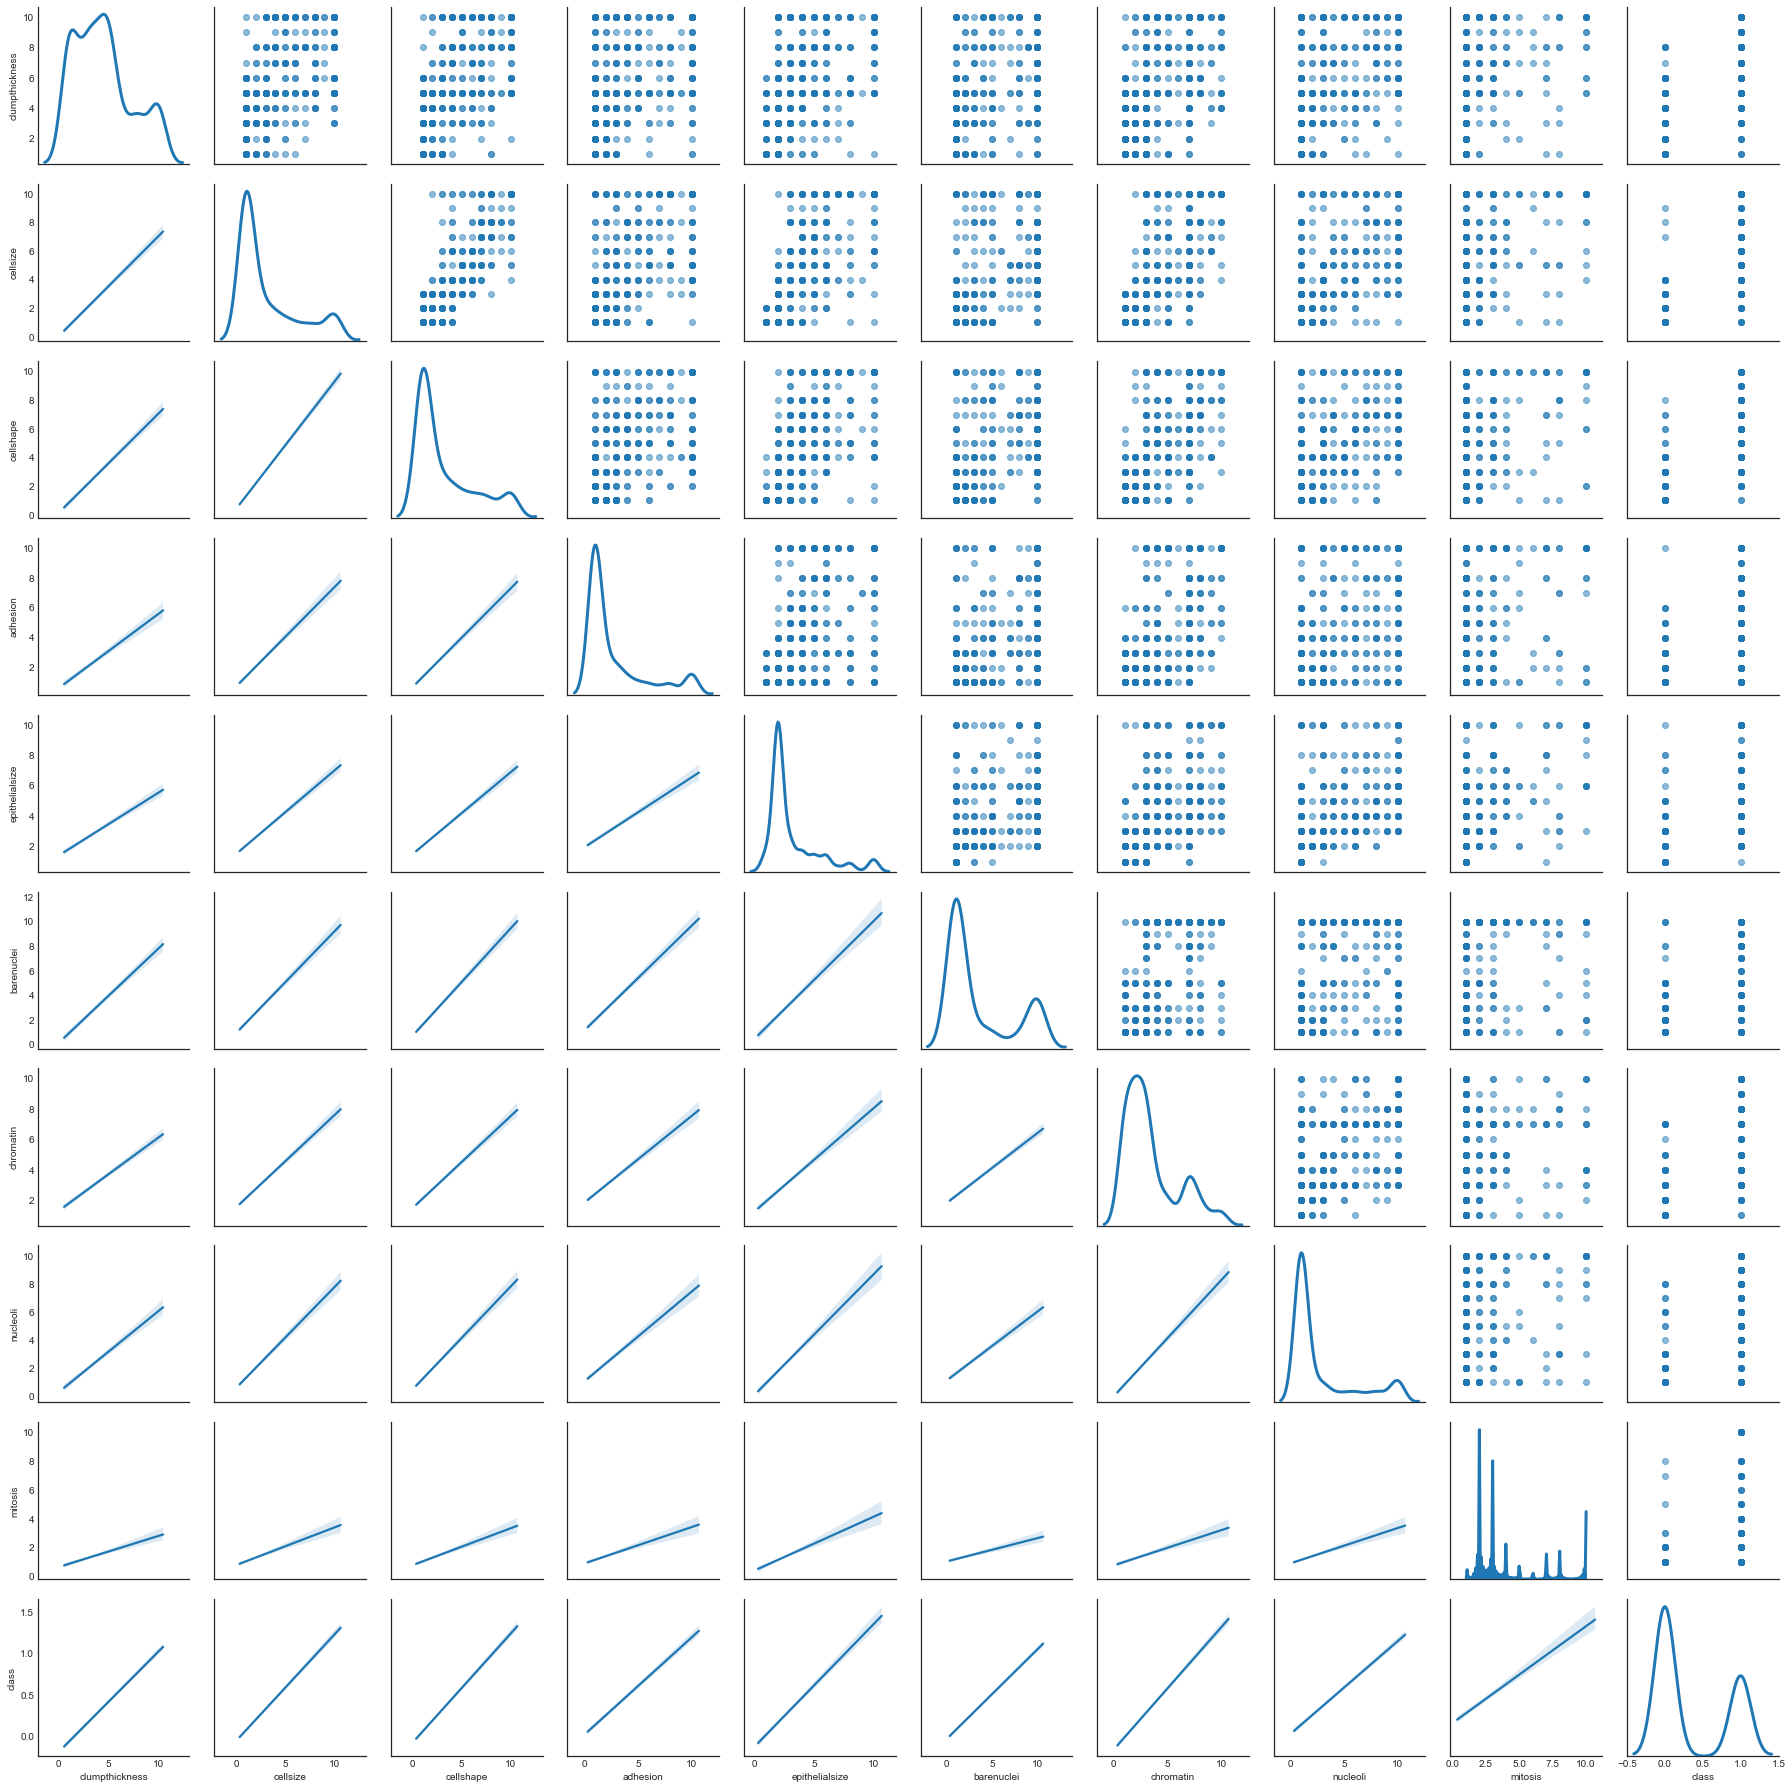

In [5]:
g = sns.PairGrid(full_df, diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)

plt.show()

We've got a class imbalance in our outcome variable -- half as many positive results as negative. We'll resample to balance those classes.

In [6]:
full_df.isnull().sum()

clumpthickness    0
cellsize          0
cellshape         0
adhesion          0
epithelialsize    0
barenuclei        0
chromatin         0
nucleoli          0
mitosis           0
class             0
dtype: int64

This data is already nice and clean! Let's do some feature selection and get to modeling.

In [7]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.utils import resample
from sklearn.feature_selection import RFE, SelectKBest
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, auc, precision_recall_curve, average_precision_score

First, let's just run a quick random forest to see where we're starting.

In [8]:
data_train, data_test = train_test_split(full_df, test_size=0.3)
X_train = data_train.loc[:, ~data_train.columns.isin(['class'])]
X_test = data_test.loc[:, ~data_test.columns.isin(['class'])]
Y_train = data_train['class']
Y_test = data_test['class']

X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)
print(rfc.score(X_test, Y_test))
print(average_precision_score(Y_test, Y_pred))
print(confusion_matrix(Y_test, Y_pred))

0.956097560976
0.889774859287
[[136   4]
 [  5  60]]


Wow. Well, we're doing great already. I guess we can run through the rest of the steps to see if anything else can compete with random forest.

## Feature Selection

We've only got 9 features, so let's engineer some more before we start paring them down.

In [9]:
for column in full_df.columns[~full_df.columns.isin(['class'])]:
    full_df[column + '_sqrt'] = np.sqrt(full_df[column])
    full_df[column + '_squared'] = full_df[column] ** 2

In [10]:
full_df.columns

Index(['clumpthickness', 'cellsize', 'cellshape', 'adhesion', 'epithelialsize',
       'barenuclei', 'chromatin', 'nucleoli', 'mitosis', 'class',
       'clumpthickness_sqrt', 'clumpthickness_squared', 'cellsize_sqrt',
       'cellsize_squared', 'cellshape_sqrt', 'cellshape_squared',
       'adhesion_sqrt', 'adhesion_squared', 'epithelialsize_sqrt',
       'epithelialsize_squared', 'barenuclei_sqrt', 'barenuclei_squared',
       'chromatin_sqrt', 'chromatin_squared', 'nucleoli_sqrt',
       'nucleoli_squared', 'mitosis_sqrt', 'mitosis_squared'],
      dtype='object')

Now let's see how they perform. We'll try RFE, Select K Best, PCA, and Random Forest. But first let's resample our classes.

In [11]:
data_train, data_test = train_test_split(full_df, test_size=0.3)

data_train_pos = data_train[data_train['class']==1]
data_train_neg = data_train[data_train['class']==0]
print(data_train_pos.shape, data_train_neg.shape)

data_train_pos = resample(data_train_pos, n_samples=len(data_train_neg))
print(data_train_pos.shape, data_train_neg.shape)

data_train = pd.concat([data_train_pos, data_train_neg]).sample(frac=1)

X_train = data_train.loc[:, ~data_train.columns.isin(['class'])]
X_test = data_test.loc[:, ~data_test.columns.isin(['class'])]
Y_train = data_train['class']
Y_test = data_test['class']

(161, 28) (317, 28)
(317, 28) (317, 28)


We'll start with random forest to get a sense of how many features we should keep.

In [12]:
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)
print(rfc.score(X_test, Y_test))
print(average_precision_score(Y_test, Y_pred))
print(confusion_matrix(Y_test, Y_test))

0.965853658537
0.923969456219
[[127   0]
 [  0  78]]


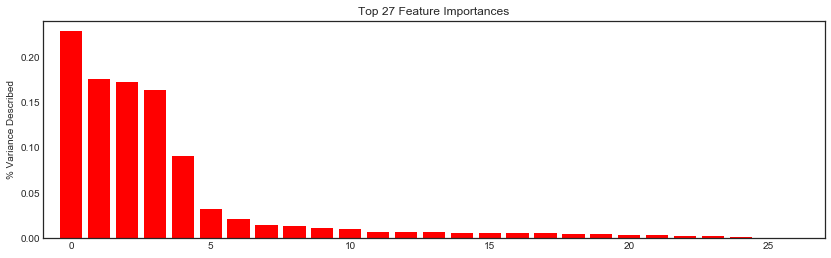

In [13]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
top_indices = indices[:1000]

# Plot the feature importances of the forest
plt.figure(figsize=(14, 4))
plt.title("Top {} Feature Importances".format(len(top_indices)))
plt.bar(range(len(top_indices)), importances[top_indices],
       color="r", align="center")
plt.xlim([-1, len(top_indices)])
plt.ylabel('% Variance Described')
plt.show()

In [14]:
for n_idx in [4, 8, 12, 16, 20, 24]:
    print('Variance explained with {} features: {}'.format(n_idx, importances[indices[:n_idx]].sum()))
print('Total Features: ' + str(len(indices)))

Variance explained with 4 features: 0.7384179994183706
Variance explained with 8 features: 0.897491490245415
Variance explained with 12 features: 0.9389272586198338
Variance explained with 16 features: 0.9646867350185011
Variance explained with 20 features: 0.9849159272491598
Variance explained with 24 features: 0.9977051074883025
Total Features: 27


In [15]:
n_indices = 12
X_train_rfc = X_train.loc[:, X_train.columns[indices[:n_indices]]]
X_test_rfc = X_test.loc[:, X_train.columns[indices[:n_indices]]]
print(X_train_rfc.shape, X_test_rfc.shape)

(634, 12) (205, 12)


In [16]:
rfe = RFE(estimator=rfc, n_features_to_select=12)
rfe.fit(X_train, Y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [17]:
skb = SelectKBest(k=12)
skb.fit(X_train, Y_train)
X_train_skb = skb.transform(X_train)
X_test_skb = skb.transform(X_test)

In [18]:
pca = PCA(n_components=12)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Let's use a less-good model to test these out, since random forest is getting it pretty much exactly right.

In [19]:
lgr = LogisticRegression()
lgr.fit(X_train, Y_train)
Y_pred = lgr.predict(X_test)
print('Without Feature Selection:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

Without Feature Selection:
[[120   7]
 [  1  77]]
0.909792578695


In [20]:
lgr.fit(X_train_rfc, Y_train)
Y_pred = lgr.predict(X_test_rfc)
print('Random Forest Feature Selection:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

Random Forest Feature Selection:
[[120   7]
 [  1  77]]
0.909792578695


In [21]:
lgr.fit(X_train_rfe, Y_train)
Y_pred = lgr.predict(X_test_rfe)
print('RFE Feature Selection:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

RFE Feature Selection:
[[120   7]
 [  2  76]]
0.901940218661


In [22]:
lgr.fit(X_train_skb, Y_train)
Y_pred = lgr.predict(X_test_skb)
print('Select K Best Feature Selection:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

Select K Best Feature Selection:
[[120   7]
 [  2  76]]
0.901940218661


In [23]:
lgr.fit(X_train_pca, Y_train)
Y_pred = lgr.predict(X_test_pca)
print('PCA Feature Decomposition:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

PCA Feature Decomposition:
[[122   5]
 [  0  78]]
0.939759036145


They're all about the same, and when I run them multiple times they're indistinguishable from each other.

## Model Selection

Let's see how all our different models compare, and if anything can do quite as well as random forest. RFE did the best, so we'll use that.

In [24]:
lgr = LogisticRegression()
lgr.fit(X_train_rfe, Y_train)
Y_pred = lgr.predict(X_test_rfe)
print('Logistic Regression:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

Logistic Regression:
[[120   7]
 [  2  76]]
0.901940218661


In [25]:
bnb = BernoulliNB()
bnb.fit(X_train_rfe, Y_train)
Y_pred = bnb.predict(X_test_rfe)
print('Naive Bayes:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

Naive Bayes:
[[127   0]
 [ 78   0]]
0.380487804878


In [26]:
knc = KNeighborsClassifier(n_neighbors=3)
knc.fit(X_train_rfe, Y_train)
Y_pred = knc.predict(X_test_rfe)
print('KNN:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

KNN:
[[119   8]
 [  3  75]]
0.883494201949


In [27]:
svc = SVC(C=10)
svc.fit(X_train_rfe, Y_train)
Y_pred = svc.predict(X_test_rfe)
print('SVC:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

SVC:
[[110  17]
 [  1  77]]
0.813525075513


In [28]:
dtc_params = {'max_depth':[4, 12, 32, None],
              'max_features':[2, 8, 'sqrt', None],
              'min_samples_split':[2, 4]}
dtc_grid = GridSearchCV(DecisionTreeClassifier(), param_grid=dtc_params)
dtc_grid.fit(X_train_rfe, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [4, 12, 32, None], 'max_features': [2, 8, 'sqrt', None], 'min_samples_split': [2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [29]:
print(dtc_grid.best_score_)
print(dtc_grid.best_params_)

0.977917981073
{'max_depth': 4, 'max_features': 8, 'min_samples_split': 4}


In [39]:
dtc = DecisionTreeClassifier(max_depth=4, max_features=8, min_samples_split=4)
dtc.fit(X_train_rfe, Y_train)
Y_pred = dtc.predict(X_test_rfe)
print('Decision Tree:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

Decision Tree:
[[115  12]
 [  1  77]]
0.858954683756


In [31]:
rfc_params = {'max_depth':[4, 8, 32, None],
              'n_estimators':[8, 24, 64],
              'min_samples_split':[2, 8],
              'max_features':[2, 8, 'sqrt', None]}
rfc_grid = GridSearchCV(RandomForestClassifier(), param_grid=rfc_params)
rfc_grid.fit(X_train_rfe, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [4, 8, 32, None], 'n_estimators': [8, 24, 64], 'min_samples_split': [2, 8], 'max_features': [2, 8, 'sqrt', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [32]:
print(rfc_grid.best_score_)
print(rfc_grid.best_params_)

0.98738170347
{'max_depth': None, 'max_features': None, 'min_samples_split': 8, 'n_estimators': 24}


In [40]:
rfc = RandomForestClassifier(max_depth=None, max_features=None, min_samples_split=8, n_estimators=24)
rfc.fit(X_train_rfe, Y_train)
Y_pred = rfc.predict(X_test_rfe)
print('Random Forest:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

Random Forest:
[[120   7]
 [  1  77]]
0.909792578695


In [34]:
gbc_params = {'max_depth':[12, 32],
              'n_estimators':[50, 100],
              'learning_rate':[0.1, 0.3]}
gbc_grid = GridSearchCV(GradientBoostingClassifier(), param_grid=gbc_params)
gbc_grid.fit(X_train_rfe, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [12, 32], 'n_estimators': [50, 100], 'learning_rate': [0.1, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [35]:
print(gbc_grid.best_score_)
print(gbc_grid.best_params_)

0.976340694006
{'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 50}


In [41]:
gbc = GradientBoostingClassifier(learning_rate=0.1, max_depth=12, n_estimators=50)
gbc.fit(X_train_rfe, Y_train)
Y_pred = gbc.predict(X_test_rfe)
print('Gradient Boosting:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

Gradient Boosting:
[[121   6]
 [  5  73]]
0.889206861884


Nothing is really doing any better than our initial trial run. And it would be hard to do better in the first place! Also, all the tuning with gridsearch didn't yield a better result than running with defaults.

In [37]:
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)
print('Full engineered feature set random forest:')
print(confusion_matrix(Y_test, Y_pred))
print(average_precision_score(Y_test, Y_pred))

Full engineered feature set random forest:
[[120   7]
 [  0  78]]
0.917647058824


One interesting point is that all of the models got misclassified 7 examples -- I wonder if these examples had specific behavior that was hard to distinguish, or if there happened to not be similar examples in the training set. Running through the notebook again does eliminate that behavior, so I'm guess it's a peculiarity in our train/test split.